In [1]:
%matplotlib inline
import pandas as pd
import os
import bidi.algorithm
import arabic_reshaper
import matplotlib.pyplot as plt

In [2]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/quotes'

In [6]:
[print(f) for f in sorted(os.listdir(fpath))]

fiqh_quran_aya_nodes.csv
fiqh_quran_aya_nodes_v2.csv
fiqh_quran_book_nodes.csv
fiqh_quran_links.csv
fiqh_quran_links_v2.csv
links_projected_books.csv
links_tfidf_books.csv
quotes_merged.csv
quran_quotes.csv
quran_quotes_ayas.csv
quran_quotes_ayas_v2.csv


[None, None, None, None, None, None, None, None, None, None, None]

In [7]:
links_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_links_v2.csv'))
nodes_aya_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_aya_nodes_v2.csv'))
nodes_books_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_book_nodes.csv'))
quotes_df = pd.read_csv(os.path.join(fpath, 'quran_quotes.csv'))

In [8]:
merged_df = links_df.merge(nodes_aya_df, left_on='Target', right_on='id')[['Source', 'Weight', 'sura_id', 'aya_id', 'sura_name', 'sura_arabic_name', 'Label']]
merged_df = merged_df.rename({'Label': 'aya_label'}, axis=1)
merged_df = merged_df.merge(nodes_books_df, left_on='Source', right_on='id')
merged_df = merged_df.drop(['Source', 'id', 'Type', 'Group', 'Label'], axis=1)

In [9]:
merged_df.to_csv(os.path.join(fpath, 'quotes_merged_v2.csv'), index=False)

In [10]:
def reshape_arabic(text):
    return bidi.algorithm.get_display(arabic_reshaper.reshape(text))

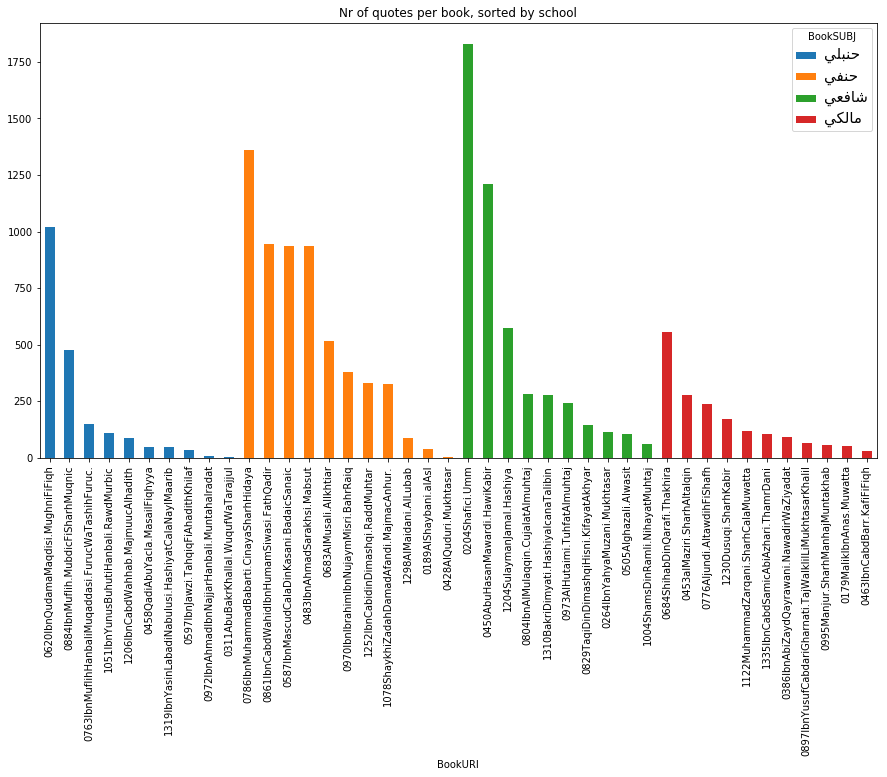

In [11]:
# Nr of quotes per book, sorted per school
count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum().unstack()
barplot = count_per_book.sort_values(list(count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Nr of quotes per book, sorted by school')
plt.show()

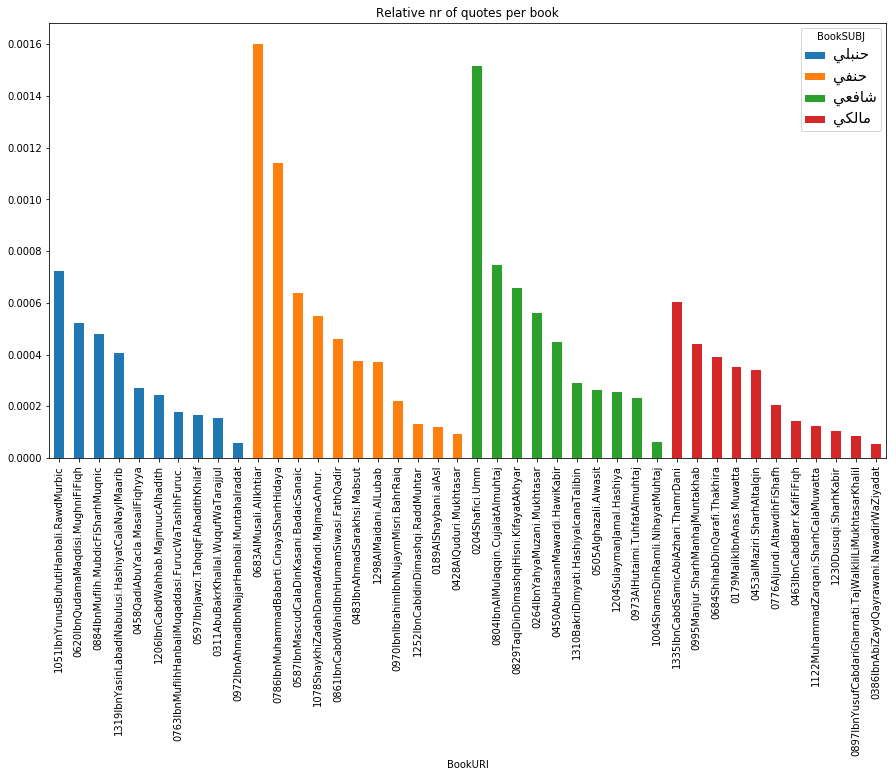

In [12]:
# Relative of quotes per book (divided by length of book) , sorted per school
nr_tokens_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Number_of_tokens'].min()
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.unstack()
barplot = rel_count_per_book.sort_values(list(rel_count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Relative nr of quotes per book')
plt.show()

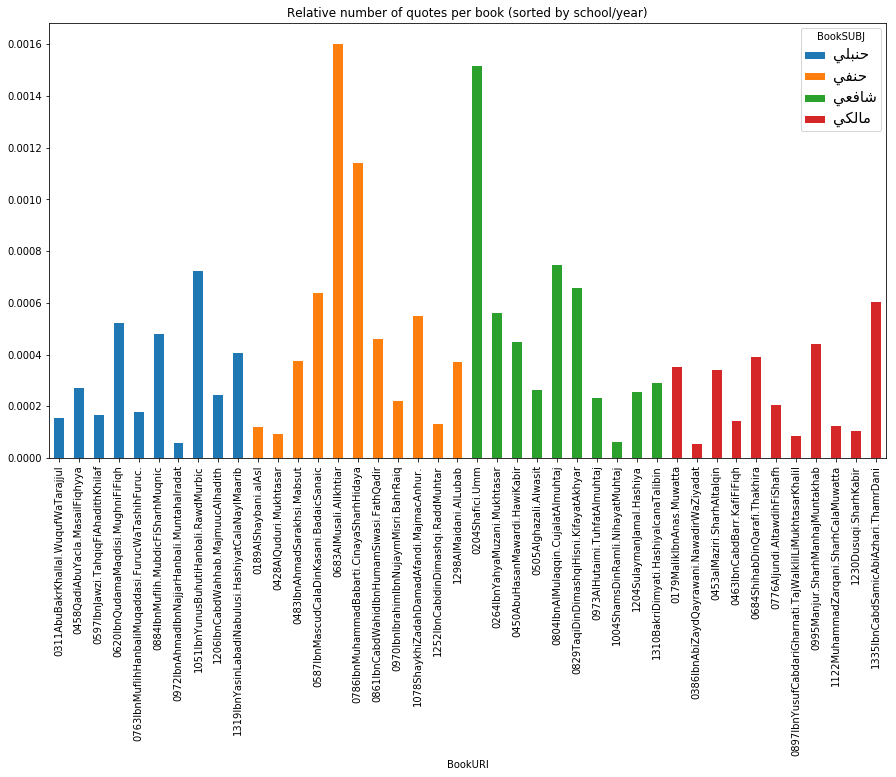

In [13]:
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.reset_index().sort_values(['BookSUBJ', 'BookURI'])
rel_count_per_book = rel_count_per_book.pivot('BookURI', 'BookSUBJ', 0).reindex(rel_count_per_book.BookURI)
barplot = rel_count_per_book.plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Relative number of quotes per book (sorted by school/year)')
plt.show()

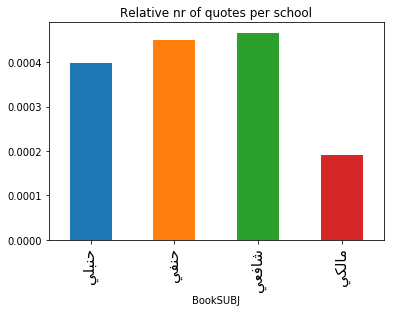

In [14]:
rel_count_per_school = merged_df.groupby('BookSUBJ')['Weight'].sum() / nr_tokens_per_book.groupby('BookSUBJ').sum() 
barplot = rel_count_per_school.plot(kind='bar')
barplot.set_xticklabels([reshape_arabic(t.get_text()) for t in barplot.xaxis.get_ticklabels()])
plt.xticks(fontsize=15)
plt.title('Relative nr of quotes per school')
plt.show()

In [15]:
import re
merged_df['Century_num'] = merged_df.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

In [16]:
count_per_century_subj = merged_df.groupby(['Century_num', 'BookSUBJ'])['Weight'].sum()

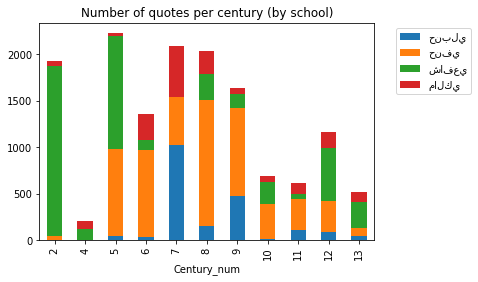

In [34]:
# Total number of quotes per century, per school
barplot = count_per_century_subj.unstack().plot(kind='bar', stacked=True)
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Number of quotes per century (by school)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [18]:
nrtokens_per_century_book = merged_df.groupby(['BookURI', 'Century_num'])['Number_of_tokens'].min()

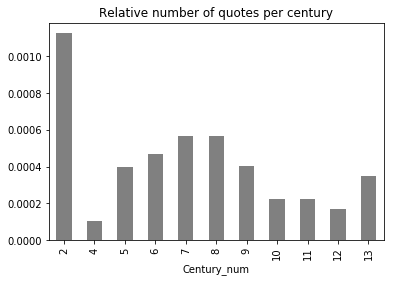

In [19]:
# Relative number of quotes per century
count_per_century = count_per_century_subj.groupby('Century_num').sum()
rel_count_per_century = count_per_century / nrtokens_per_century_book.groupby(['Century_num']).sum() 
barplot = rel_count_per_century.plot(kind='bar', color='grey')
plt.title('Relative number of quotes per century')
plt.show()

## Which verses are cited most often?
Which verses have the most citations in total? And by how many books are they cited?

In [20]:
counts_per_verse = pd.DataFrame({'nr_books': merged_df.aya_label.value_counts(), 
                                 'nr_citations': merged_df.groupby('aya_label')['Weight'].sum()})
counts_per_verse.sort_values('nr_citations', ascending=False).head(20)

,nr_books,nr_citations
Al-Baqarah 196,29,238
Al-Baqarah 282,28,228
An-Nisa' 43,32,201
An-Nisa' 11,28,192
Al-Ma'idah 95,29,190
An-Nisa' 23,28,160
Al-Baqarah 233,24,155
Al-Ma'idah 6,29,150
Al-Baqarah 228,27,137
At-Talaq 2,25,130


In [21]:
# What are the verses cited by most books?
print('What are the verses cited by most books?')
counts_per_verse.sort_values('nr_books', ascending=False).head(10)

What are the verses cited by most books?


,nr_books,nr_citations
An-Nisa' 43,32,201
Al-Baqarah 196,29,238
Al-Ma'idah 6,29,150
Al-Ma'idah 95,29,190
An-Nisa' 23,28,160
An-Nisa' 11,28,192
Al-Baqarah 282,28,228
Al-Baqarah 184,27,100
Al-Ikhlas 1,27,68
Al-Baqarah 228,27,137


## What are the most cited verses per school?
And by how many books are they cited?

In [22]:
from IPython.display import display
# What are the verses cited by most books, per school?
for school in merged_df.BookSUBJ.unique():
    print(school)
    df_sub = merged_df[merged_df.BookSUBJ==school]
    counts_per_verse_sub = pd.DataFrame({'nr_books': df_sub.aya_label.value_counts(), 
                                 'nr_citations': df_sub.groupby('aya_label')['Weight'].sum()})
    print('Total nr of books in this school: ', df_sub.BookURI.nunique())
    display(counts_per_verse_sub.sort_values('nr_citations', ascending=False).head(20))
    print('\n')

مالكي
Total nr of books in this school:  11


,nr_books,nr_citations
An-Naziat 20,1,51
An-Nisa' 11,7,33
An-Nisa' 43,7,31
Al-Baqarah 282,6,25
An-Nisa' 6,4,23
Al-Ma'idah 6,5,20
An-Nisa' 23,5,20
Al-Baqarah 196,5,19
An-Nisa' 25,5,16
Al-Baqarah 237,5,16




شافعي
Total nr of books in this school:  10


,nr_books,nr_citations
Al-Baqarah 282,9,110
Al-Ma'idah 95,9,79
An-Nisa' 43,10,78
Al-Baqarah 196,9,75
At-Talaq 2,9,69
Al-Baqarah 229,8,62
Al-Baqarah 228,8,55
Al-Mumtahina 10,6,54
Al-Baqarah 237,8,54
An-Nisa' 11,8,52




حنفي
Total nr of books in this school:  11


,nr_books,nr_citations
Al-Baqarah 196,10,112
Al-Baqarah 233,9,98
An-Nisa' 11,9,76
Al-Baqarah 282,9,71
An-Nisa' 23,9,71
Al-Ma'idah 95,9,67
An-Nisa' 24,8,66
An-Nisa' 43,9,65
At-Talaq 4,9,63
Al-Ma'idah 6,10,57




حنبلي
Total nr of books in this school:  10


,nr_books,nr_citations
Al-Baqarah 196,5,32
An-Nisa' 11,4,31
Al-Ma'idah 95,6,30
An-Nisa' 43,6,27
Al-Ikhlas 1,7,24
Al-Baqarah 184,5,24
Al-Ma'idah 6,5,23
Al-Baqarah 282,4,22
Al-Ma'idah 89,3,22
Al-Baqarah 228,5,21


## NLP approaches

In [23]:
adj_df = merged_df.pivot('BookURI', 'aya_label', 'Weight').fillna(0)

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(adj_df.values)
print(tfidf.shape)

(42, 2110)


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(tfidf, tfidf)
similarities.shape

(42, 42)

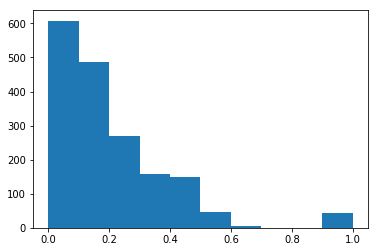

In [26]:
plt.hist(similarities.flatten());

In [27]:
import numpy as np
similarities_df = pd.DataFrame(similarities, columns=adj_df.index, index=adj_df.index)
np.fill_diagonal(similarities_df.values, 0)

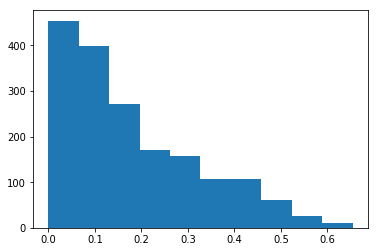

In [28]:
plt.hist(similarities_df.values.flatten());

In [29]:
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE

dist = cosine_distances(tfidf, tfidf)

X_embedded = TSNE(n_components=2, metric='precomputed').fit_transform(dist)
print(X_embedded.shape)

(42, 2)


In [30]:
df_books_embedded = pd.DataFrame(X_embedded, index=adj_df.index, columns=['x', 'y'])

In [31]:
df_books_embedded.head()

,x,y
BookURI,,
0179MalikIbnAnas.Muwatta,20.153069,94.611664
0189AlShaybani.alAsl,-66.506165,95.740707
0204Shafici.Umm,-39.102356,12.395356
0264IbnYahyaMuzani.Mukhtasar,44.302643,56.159382
0311AbuBakrKhallal.WuqufWaTarajjul,-107.270370,-96.664490


In [32]:
df_books_embedded = df_books_embedded.merge(nodes_books_df, right_on='BookURI', left_on='BookURI')

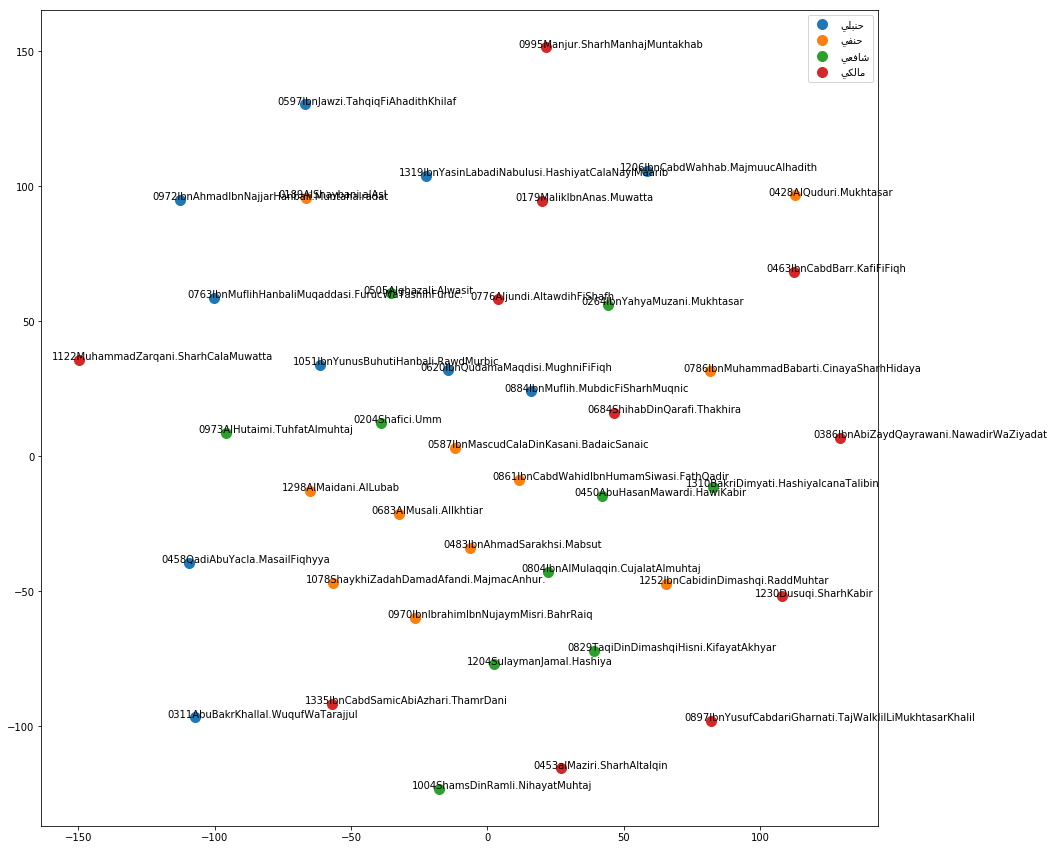

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
for subj, group in df_books_embedded.groupby('BookSUBJ'):
    ax.plot(group.x, group.y, label=reshape_arabic(subj), marker='o', linestyle='', markersize=10)
    for x,y,s in zip(group.x, group.y, group.BookURI):
        ax.text(x-10, y, s)
ax.legend()
plt.show()

## Network analysis

In [ ]:
import networkx as nx

In [ ]:
nw_similarities = nx.from_pandas_adjacency(similarities_df)
list(nw_similarities.edges(data=True))[:10]

In [ ]:
nx.to_pandas_edgelist(nw_similarities).to_csv(os.path.join(fpath, 'links_tfidf_books.csv'), index=False)

In [ ]:
network = nx.from_pandas_edgelist(links_df, source='Source', target='Target', edge_attr='Weight')

In [ ]:
nx.algorithms.is_bipartite(network)

In [ ]:
# Get projected graphs
book_ids = links_df.Source.unique()
nw_books_jaccard = nx.algorithms.bipartite.overlap_weighted_projected_graph(network, book_ids)
nw_books_overlap

In [ ]:
list(nw_books.edges(data=True))[:10]

In [ ]:
nx.to_pandas_edgelist(nw_books).to_csv(os.path.join(fpath, 'links_projected_books.csv'), index=False)